In [3]:
using Revise

In [4]:
using ProgressMeter
using KSVD
using WAV
using Plots
using PyCall
using FFTW
using DelimitedFiles
using DataFrames, Query
using DSP
using JLD2, FileIO

In [5]:
display = pyimport("IPython.display");

In [6]:
lr = pyimport("librosa");

In [7]:
gr()

Plots.GRBackend()

## Data

### TSVs

In [8]:
dp = "/home/zach/Data/maestro/maestro-v2.0.0/2004/"
files = readdir(dp);
wavs = [i for i in files if endswith(i, ".wav")];

In [9]:
"Loads a TSV file and adds columns for on/off samples"
function load_tsv(fn, sr)
    tsv_f, cols = readdlm(fn, '\t', header=true);
    cols = split(cols[1][3:end], ',');

    tsv_df = DataFrame(tsv_f, [:on_time, :off_time, :note, :velocity]);
    tsv_df[!,:on_sample] = lr.time_to_samples(tsv_df[:,:on_time], sr);
    tsv_df[!,:off_sample] = lr.time_to_samples(tsv_df[:,:off_time], sr);
    return tsv_df
end

load_tsv

In [380]:
"""
Gets the MIDI notes and velocities that occur in a given frame
"""
function get_frame_notes(tsv_df, frame)
    on_samp, off_samp = tsv_df.on_sample[frame], tsv_df.on_sample[frame+1]
    notes_df = tsv_df |> @filter((on_samp <= _.on_sample < off_samp) || (on_samp < _.off_sample < off_samp)) |> DataFrame
    return notes_df[:,[:note, :velocity]]
end

get_frame_notes

In [11]:
tsvs = [dp*wavs[i][1:end-4]*".tsv" for i in 1:length(wavs)];

In [12]:
tsv_dfs = [load_tsv(f, 44100) for f in tsvs];

### WAVs

In [13]:
""" Gets a frame from an audio file given a list of onsets and an index
"""
function get_frame(wav, onsets, n)
    return wav[onsets[n]:onsets[n+1]]
end

get_frame

In [14]:
"""
Gets all frames of audio from an audio file as a list given the file and the list of onset samples
"""
function get_frames(wav, onset_samples)
    frames = [get_frame(wav, onset_samples, i) for i in 1:length(onset_samples)-1];
    return frames
end

get_frames

In [15]:
"""
Zero pads or crops frames to be length l samples
"""
function zero_pad_crop(x, l)
    if length(x) < l
        return [x; zeros(eltype(x), l-length(x))]
    else
        return x[1:l]
    end
end

zero_pad_crop

In [16]:
"""
Downsample and crop frames and concatenate into array
"""
function prepare_frames(frames, ds_factor=8, frame_len=512)
    frames = @showprogress "resampling: " [Filters.resample(i, 1/ds_factor) for i in frames] # downsample
    frames = hcat((@showprogress "cropping: " [zero_pad_crop(x, frame_len) for x in frames])...); # crop and concatenate
    return frames
end

prepare_frames

In [17]:
function wavplot(x, sr=44100)
    plot((1:length(x))./sr, x)
end

wavplot (generic function with 2 methods)

### Data Test

In [266]:
loaded_wavs = [wavread(dp*x)[1] for x in wavs[1:3]];

In [267]:
frames_ex = @showprogress "getting frames" [get_frames(x, tsv_dfs[i].on_sample) for (i,x) in enumerate(loaded_wavs)];
frames_ex = vcat(frames_ex...);

getting frames100%|█████████████████████████████████████| Time: 0:00:00


In [268]:
frames = prepare_frames(frames_ex);

resampling: 100%|███████████████████████████████████████| Time: 0:00:58


In [21]:
n_onsets = 30
plot((1:onsets[n_onsets]*512)/sr, wav_ex[1:onsets[n_onsets]*512,1], 
    lab="Audio",
    xlabel="Time",
    ylabel="Amplitude",
    title="Example Waveform with Onsets")
vline!(onset_times[1:n_onsets], lab="Onsets")

UndefVarError: UndefVarError: onsets not defined

# Utility Functions

In [269]:
function midi2key(note)
    note = convert(Int, note)
    if note < 108 && note > 20
        return note - 20
    else
        return nothing
    end
end

midi2key (generic function with 1 method)

In [344]:
function key2midi(note)
    if note <= 88 && note >= 0
        return note + 20
    end
end

key2midi (generic function with 1 method)

# K-SVD Part

In [271]:
JLD2.@load "vars/dictionary.jld2" Z D

2-element Array{Symbol,1}:
 :Z
 :D

In [272]:
num_fingers = 10
num_keys = 88

D, Z = ksvd(frames[:,1:4000],
    num_keys,        # number of items in dictionary (88 keys on piano)
    max_iter = 100,  # max iterations of K-SVD
    max_iter_mp = 40, # max iterations of matching pursiot
    sparsity_allowance = round((num_keys-num_fingers)/num_keys, digits=2) # stop when at least 78/88 keys are 0
)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:27


([0.034817070385706 0.0083694518071903 … -0.047550415900655896 -0.03891033343489225; 0.031073592961398333 0.01823171091770781 … -0.10035580625460516 -0.09646593988674435; … ; -0.023431928559310818 -0.025752292686357304 … 0.020373811504311973 -0.010090697419099267; -0.04788735192188274 -0.04536214738663306 … 0.02189307596275416 -0.005080989801479385], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.08350571551502928 -0.02043423865255778 … 0.0 0.0; 0.0 0.0187062339492543 … 0.45346946096210866 0.0])

In [273]:
JLD2.@save "vars/dictionary.jld2" Z D

### Inspect Dictionary Learned

In [274]:
frame_len = 512;
sr = 44100;
ds_factor = 8;

In [275]:
ffts = hcat([fft(D'[i,:])[1:Int(frame_len/2)] for i in 1:size(D', 1)]...); 

In [276]:
ffts = sortslices(abs.(ffts), by=x->argmax(x), dims=2);

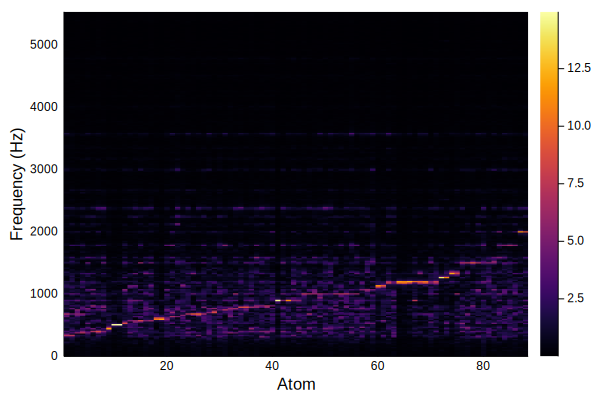

In [404]:
atoms = heatmap(1:88,range(0, 5512; length=256), ffts,
    xlabel="Atom",
    ylabel="Frequency (Hz)",
)

In [282]:
savefig("paper/figs/atoms.png")

In [49]:
using IterativeSolvers
using SparseArrays

In [283]:
function OMP(v, Φ, m)
    r = v;
    Λ = [];
    z = [];

    for t = 1:m
        dots = Φ'*r
        λ = argmax(abs.(dots))
        ϕ = dots[λ]

        if !any(Λ .== λ)
            push!(Λ, λ)
        end

        temp = Φ[:, Λ]

        z = lsqr(temp, v)

        r = v-temp*z
        r = r[:]

    end
    ret = spzeros(size(Φ, 2));
    ret[Λ] = z;
    return ret
end

OMP (generic function with 1 method)

In [330]:
n = 3
fr_ex = frames[:,n];
z_ex = D*Vector(OMP(fr_ex, D, 10));
z_full_ex = D*Vector(OMP(fr_ex, D, 88));

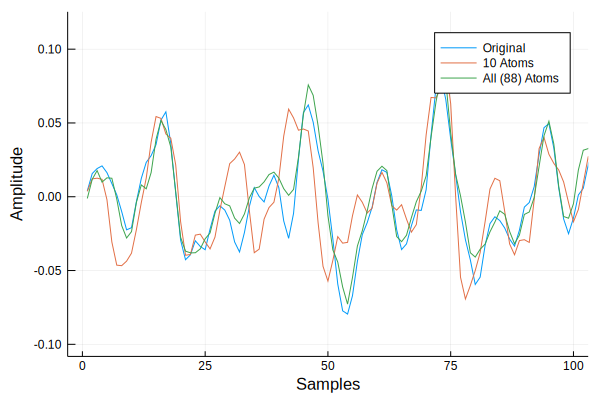

In [399]:
plot([fr_ex z_ex z_full_ex], 
    lab=["Original", "10 Atoms", "All (88) Atoms"], 
    ylabel="Amplitude",
    xlabel="Samples",
    xlim=[0,100])

In [400]:
savefig("paper/figs/reconstructed.png")

## Evaluation

In [382]:
corrects = []
@showprogress for n in 1:size(tsv_dfs[1], 1)-1
    ẑ = OMP(frames[:,n], D, 10)
    midi_guess = key2midi.(ẑ.nzind);
    midi_actual = get_frame_notes(tsv_dfs[1], n).note;
    #println("guess: ",midi_guess, " actual: ", midi_actual)
    push!(corrects, sum([x in midi_actual ? 1 : 0 for x in midi_guess]))
end

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

BoundsError: BoundsError: attempt to access 7894-element Array{Int64,1} at index [7895]

In [397]:
losses = []
@showprogress "fingers " for nfingers in 1:10
    loss = 0
    @showprogress "training..." for n in 1:size(tsv_dfs[1], 1)-1
        X = frames[:,n]
        Z = OMP(X, D, nfingers)
        loss += norm(X-D*Z)
    end
    push!(losses, loss)
end

training...100%|████████████████████████████████████████| Time: 0:00:00
training...100%|████████████████████████████████████████| Time: 0:00:01
training...100%|████████████████████████████████████████| Time: 0:00:02
training...100%|████████████████████████████████████████| Time: 0:00:04
training...100%|████████████████████████████████████████| Time: 0:00:03
training...100%|████████████████████████████████████████| Time: 0:00:04
training...100%|████████████████████████████████████████| Time: 0:00:05
training...100%|████████████████████████████████████████| Time: 0:00:07
training...100%|████████████████████████████████████████| Time: 0:00:15
training...100%|████████████████████████████████████████| Time: 0:00:26
fingers 100%|███████████████████████████████████████████| Time: 0:01:12


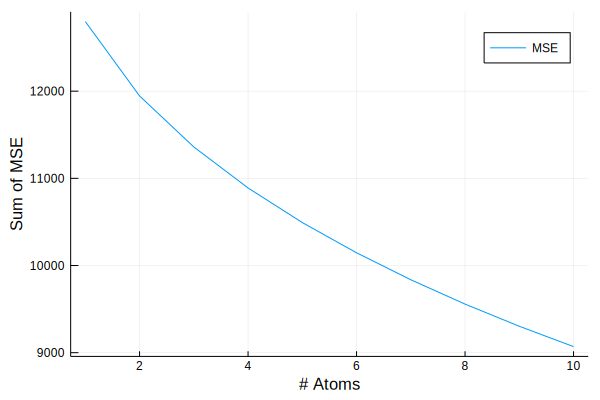

In [398]:
plot(losses,
    lab="MSE",
    xlabel="# Atoms",
    ylabel="Sum of MSE"
)

In [385]:
sum(corrects) / length(corrects)

0.19130875459267704